In [1]:
import torch
from torch.utils.data import DataLoader
import torch.backends.cudnn as cudnn
import numpy as np
import torch.nn.functional as F
import sys
import os 
from data import *
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split

In [2]:
# simple vgg like network
class SmallConv(torch.nn.Module):
    def __init__(self):
        super(SmallConv, self).__init__()

        #Input channels = 4, output channels = 32
        self.conv1 = torch.nn.Conv2d(4, 32, kernel_size=5, stride=2)
        self.conv2 = torch.nn.Conv2d(32, 64, kernel_size=5, stride=2)
        self.bn1 = torch.nn.BatchNorm2d(64)
        self.conv3 = torch.nn.Conv2d(64, 128, kernel_size=2, stride=2)
        self.conv4 = torch.nn.Conv2d(128, 256, kernel_size=2, stride=2)
        self.bn2 = torch.nn.BatchNorm2d(256)
        self.conv5 = torch.nn.Conv2d(256, 512, kernel_size=2, stride=2)
        self.conv6 = torch.nn.Conv2d(512, 512, kernel_size=2, stride=2)
        self.bn3 = torch.nn.BatchNorm2d(512)
        self.conv7 = torch.nn.Conv2d(512, 1024, kernel_size=4, stride=1)
        self.avg_pool = torch.nn.AdaptiveAvgPool2d((1,1))

#         512 input features, 28 output features
        self.classifier = torch.nn.Linear(1024, 28)


    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.conv2(x)
        x = F.relu(self.bn1(x))
        x = F.relu(self.conv3(x))
        x = self.conv4(x)
        x = F.relu(self.bn2(x))
        x = F.relu(self.conv5(x))
        x = self.conv6(x)
        x = F.relu(self.bn3(x))
        x = F.relu(self.conv7(x))
        x = self.avg_pool(x)
        x = x.view(x.shape[0], -1)
        x = self.classifier(x)
        x = F.sigmoid(x)
        return x
    
model = SmallConv()
# x = torch.tensor(np.empty((8,4,512,512)), dtype=torch.float32)
# y = model.forward(x)
# y.shape

In [3]:
data_dir = 'data/train'
train_df = pd.read_csv('data/train.csv')
train_idx, val_idx = train_test_split(np.arange(len(train_df)), test_size=0.2, shuffle=True)
train_loader = create_data_loader(data_dir, train_df, load_target=True, shuffle=True, idx=train_idx, batch_size=64)
val_loader = create_data_loader(data_dir, train_df, load_target=True, shuffle=False, idx=val_idx)

In [4]:
def eval_model(model, val_loader, score=True):
    pred = None
    gt = None
    model = model.eval()
    with torch.no_grad():
        for i, data in enumerate(tqdm(val_loader)):
            x, t = data
            x = x.to(device)
            t = t.to(device)
            y = model(x).detach().cpu().numpy()
            if i > 0:
                pred = np.vstack([pred, y])
                if score:
                    gt = np.vstack([gt, t.cpu().numpy()])
            else:
                pred = y
                if score:
                    gt = t.cpu().numpy()

    if score:
        return f1_score(gt, (pred > 0.2).astype(int), average='macro')
    else:
        return pred

def train_model(model, n_epochs, optimizer, train_loader, criterion, losses, scores):
    model = model.train()
    for j, epoch in enumerate(range(n_epochs)):  # loop over the dataset multiple times
        losses.append([])
        running_loss = 0.0
        for i, data in enumerate(tqdm(train_loader), 0):
            # get the inputs
            inputs, labels = data
            labels = labels.to(device)
            inputs = inputs.to(device)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # print statistics
            losses[-1].append(loss.item())
            running_loss += loss.item()
    #         if i % 100 == 99:    # print every 100 mini-batches
    #             print('[%d, %5d] loss: %.3f' %
    #                   (epoch + 1, i + 1, running_loss / 100))
    #             running_loss = 0.0

        score = eval_model(model, val_loader)
        scores.append(score)

        print("Epoch %d average loss %f, val f1_score %f" % (j, np.mean(losses[-1]), score))

losses = []
scores = []
device_ids = [4,5]
device = torch.device("cuda:%d"%device_ids[0])
torch.cuda.set_device(device_ids[0])
cudnn.benchmark = True
model = model.to(device)
# model = torch.nn.DataParallel(model, device_ids)
criterion = torch.nn.BCELoss()
criterion.to(device)
optimizer = torch.optim.Adam(model.parameters())

In [5]:
n_epochs = 15
train_model(model, n_epochs, optimizer, train_loader, criterion, losses, scores)
print('Finished Training')

100%|██████████| 49/49 [00:15<00:00,  3.17it/s]
/usr/local/lib/python3.5/dist-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
  0%|          | 0/389 [00:00<?, ?it/s]

Epoch 0 average loss 0.166531, val f1_score 0.085996


  0%|          | 0/389 [00:00<?, ?it/s]

Epoch 1 average loss 0.155961, val f1_score 0.096531


  0%|          | 0/389 [00:00<?, ?it/s]

Epoch 2 average loss 0.149194, val f1_score 0.147657


  0%|          | 0/389 [00:00<?, ?it/s]

Epoch 3 average loss 0.140738, val f1_score 0.221336


  0%|          | 0/389 [00:00<?, ?it/s]

Epoch 4 average loss 0.133261, val f1_score 0.244852


  0%|          | 0/389 [00:00<?, ?it/s]

Epoch 5 average loss 0.125758, val f1_score 0.251803


  0%|          | 0/389 [00:00<?, ?it/s]

Epoch 6 average loss 0.118497, val f1_score 0.289759


  0%|          | 0/389 [00:00<?, ?it/s]

Epoch 7 average loss 0.111690, val f1_score 0.308966


  0%|          | 0/389 [00:00<?, ?it/s]

Epoch 8 average loss 0.104153, val f1_score 0.321331


  0%|          | 0/389 [00:00<?, ?it/s]

Epoch 9 average loss 0.093827, val f1_score 0.339495


  0%|          | 0/389 [00:00<?, ?it/s]

Epoch 10 average loss 0.080449, val f1_score 0.340370


  0%|          | 0/389 [00:00<?, ?it/s]

Epoch 11 average loss 0.061512, val f1_score 0.340365


  0%|          | 0/389 [00:00<?, ?it/s]

Epoch 12 average loss 0.042109, val f1_score 0.317246


  0%|          | 0/389 [00:00<?, ?it/s]

Epoch 13 average loss 0.027654, val f1_score 0.332203


100%|██████████| 49/49 [00:15<00:00,  3.16it/s]


Epoch 14 average loss 0.017649, val f1_score 0.322452
Finished Training


In [5]:
score = eval_model(model, val_loader)
print(score)

100%|██████████| 49/49 [00:15<00:00,  3.20it/s]


0.38136943973716697


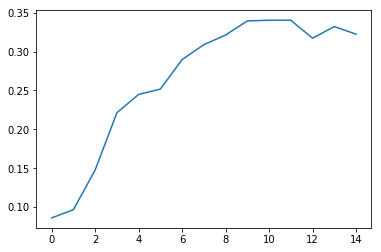

In [7]:
plt.plot(scores)

In [8]:
sub_df = pd.read_csv('data/sample_submission.csv')
test_loader = create_data_loader('data/test', sub_df, load_target=False, shuffle=False)
test_pred = eval_model(model, test_loader, score=False)
test_pred = (test_pred > 0.2).astype(int)
sub_df.Predicted = [' '.join(map(str, test_pred[i].nonzero()[0])) for i,x in enumerate(test_pred)]
sub_df.to_csv('submision.csv', index=False)
sub_df.head()

100%|██████████| 92/92 [00:25<00:00,  3.63it/s]


,Id,Predicted
0,00008af0-bad0-11e8-b2b8-ac1f6b6435d0,0 2
1,0000a892-bacf-11e8-b2b8-ac1f6b6435d0,1 5 25
2,0006faa6-bac7-11e8-b2b7-ac1f6b6435d0,0 23
3,0008baca-bad7-11e8-b2b9-ac1f6b6435d0,0 25
4,000cce7e-bad4-11e8-b2b8-ac1f6b6435d0,23
